# Neural Style Transfer V2

Name: Anthony Kevin Oktavius

One of the way can be seen at this colab notebook title: Neural Style Transfer with Karya Seni Rupa

Library Import

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import cv2
import shutil
import zipfile
import os
import zipfile
import gc
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import xml.etree.ElementTree as ET # Parse XML Data.

from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder

See current device specification.

In [ ]:
print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16191122007258703765
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13890289664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7770632974856046195
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


See if the system supports CUDA. If it does, use the CPU instead.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Preparation & Preprocessing Test

Want to use custom style and content image? Type in the URL and we'll download it for U.

In [ ]:
#@markdown ### Image URL (right click -> copy image address):
content_image_url = 'https://cdn.pixabay.com/photo/2019/06/11/15/42/corgi-face-4267312__480.jpg' #@param {type:"string"}
style_image_url = 'https://hub.packtpub.com/wp-content/uploads/2018/05/iStock-641678392.jpg'#@param {type:"string"}





Initialize Dataset Directory

In [ ]:
neural_style_transfer_dataset_directory = "./drive/MyDrive/Dataset/Neural Style Transfer"
image_names = [sample_file for sample_file in os.listdir(neural_style_transfer_dataset_directory) if os.path.isfile(f"{neural_style_transfer_dataset_directory}/{sample_file}")]

print(image_names)
print(f"Number of datasets available: {len(image_names)}")

['Monas.jpg', 'Wajah.jpg', 'mega-mendung.jpg', 'Batik 1.jpg', 'Batik 2.png', 'fokus-saat-bekerja.jpg', 'Orang Berfoto.jpg', 'keramik 1.jpg', 'keramik 2.jpg', 'Batik 3.jpg', 'Wayang Kulit.jpg', 'Sample_0_MNIST.png', 'Sample_1_MNIST (1).png', 'Sample_0_MNIST (2).png']
Number of datasets available: 14


Visualize Collected Images.

List index out of range.
List index out of range.


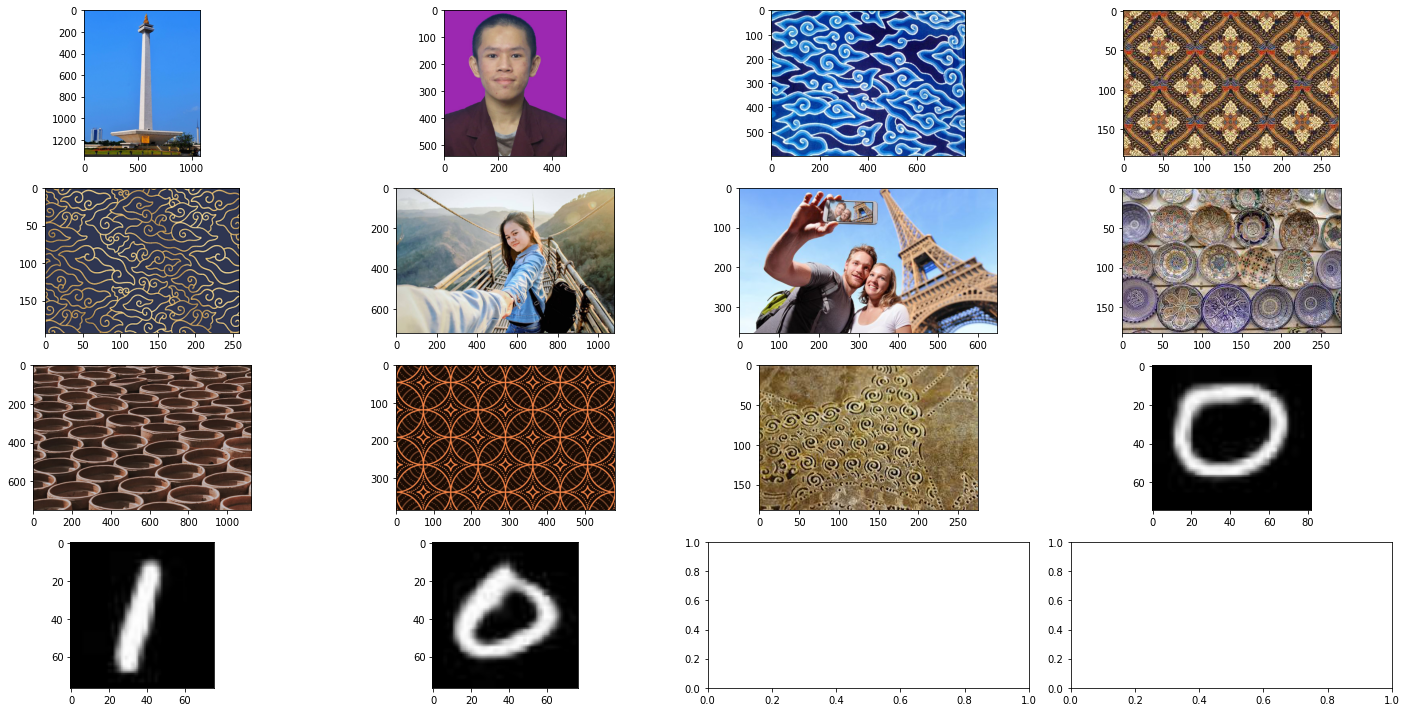

In [ ]:
from os.path import isfile
N_ROWS = 4
N_COLS = 4
index = 0

fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (20, 10))

for row in range(0, N_ROWS):
  for col in range(0, N_COLS):
    try:
      image_name = image_names[index]
      full_image_path = f"{neural_style_transfer_dataset_directory}/{image_name}"

      if os.path.isfile(full_image_path):
        image = Image.open(full_image_path)
        axes[row][col].imshow(image)

      index += 1
    except IndexError as e:
      print("List index out of range.")
    
plt.tight_layout()
plt.show()

Visualize Collected Images (with transformations)

List index out of range.
List index out of range.


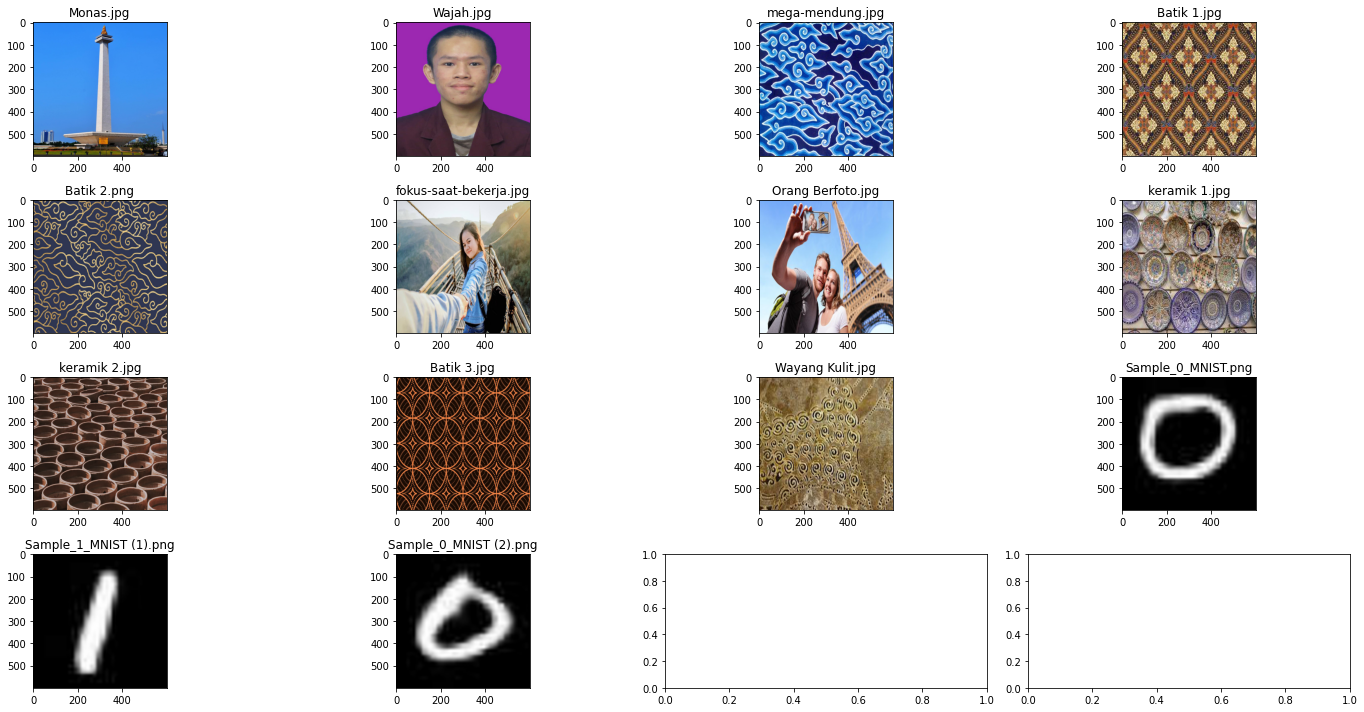

In [ ]:
from os.path import isfile
index = 0

fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (20, 10))

for row in range(0, N_ROWS):
  for col in range(0, N_COLS):
    try:
      image_name = image_names[index]
      full_image_path = f"{neural_style_transfer_dataset_directory}/{image_name}"

      if os.path.isfile(full_image_path):
        image = Image.open(full_image_path)
        image = image.resize((600, 600), Image.LANCZOS)
        axes[row][col].imshow(image)
        axes[row][col].set_title(image_name)

      index += 1
    except IndexError as e:
      print("List index out of range.")
    
plt.tight_layout()
plt.show()

Visualize Collected Images (Apply the transformation, then reset the transformation) => Only Resize.

List index out of range.
List index out of range.


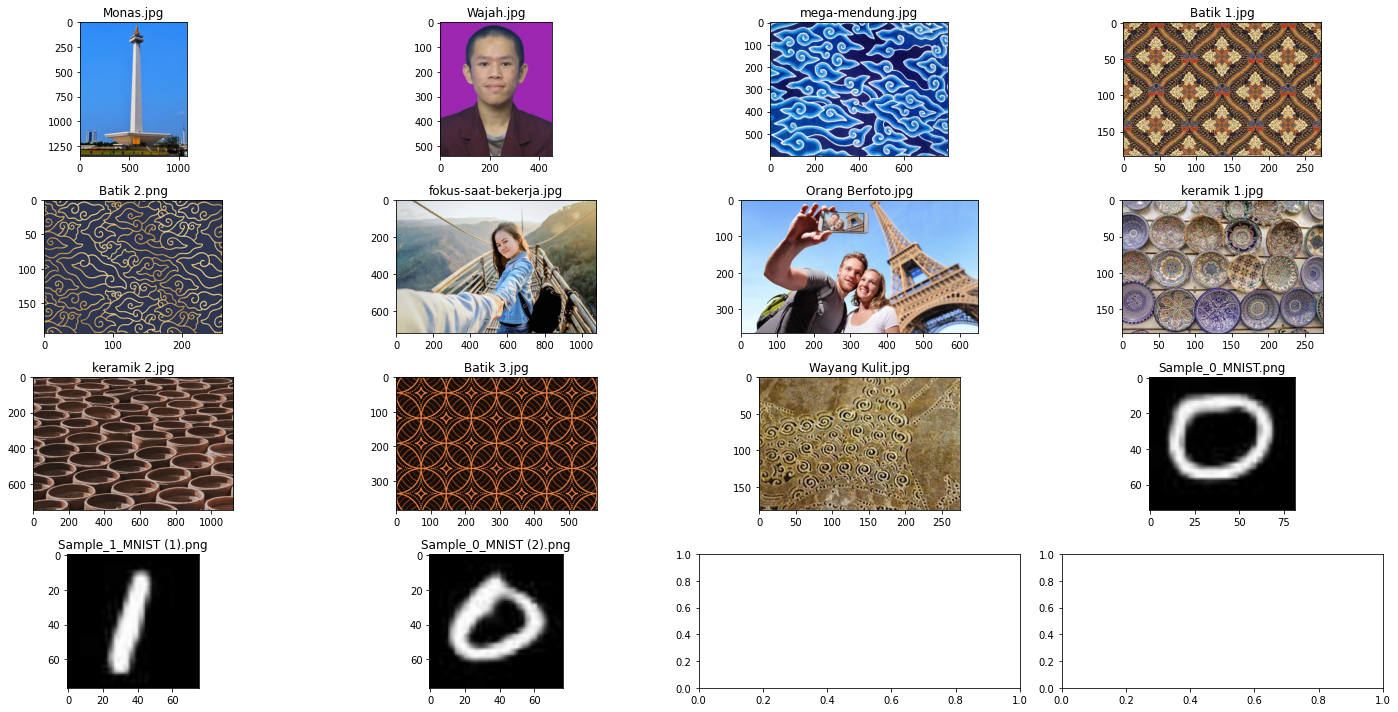

In [ ]:
from os.path import isfile
index = 0

fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (20, 10))

for row in range(0, N_ROWS):
  for col in range(0, N_COLS):
    try:
      image_name = image_names[index]
      full_image_path = f"{neural_style_transfer_dataset_directory}/{image_name}"

      if os.path.isfile(full_image_path):
        image = Image.open(full_image_path)
        original_size_image = image.size
        image = image.resize((600, 600), Image.LANCZOS)
        image = image.resize(original_size_image, Image.LANCZOS)
        axes[row][col].imshow(image)
        axes[row][col].set_title(image_name)

      index += 1

    except IndexError as e:
      print("List index out of range.")
    
plt.tight_layout()
plt.show()

## Data Modelling 1

Below is the model architecture that we'll implement.

<img src="https://miro.medium.com/v2/resize:fit:1294/1*ZgW520SZr1QkGoFd3xqYMw.jpeg" height = "300"/>

### Function and Module Testing

Define Sample Directory and Sample Image.

In [ ]:
print(neural_style_transfer_dataset_directory)
sample_content_image_path = f"{neural_style_transfer_dataset_directory}/Sample_0_MNIST.png"
sample_style_image_path = f"{neural_style_transfer_dataset_directory}/Sample_0_MNIST (2).png"
sample_style_image_2_path = f"{neural_style_transfer_dataset_directory}/Sample_1_MNIST (1).png"

./drive/MyDrive/Dataset/Neural Style Transfer


Define Transformation Module

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((800, 800), Image.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # Based on ImageNet normalize.
])

function_testing_transform = transforms.Compose([
    transforms.Resize((77, 77), Image.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5]), # Based on ImageNet normalize.
])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Gram Matrix

Deep Dive into gram matrix's output and see how the values are correlated.

Current Sample Style Image: torch.Size([3, 800, 800])
This is the gram matrix that shows correlation between each channels: 


<Axes: >

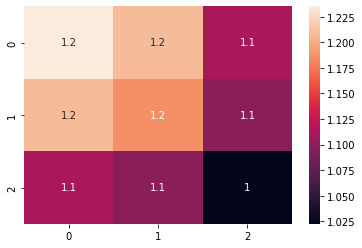

In [ ]:
# Compute gram matrices.
def get_gram(matrix):
  _, channels, height, width = matrix.size()
  gram_matrix = matrix.view(channels, height * width)
  gram_matrix = torch.mm(gram_matrix, gram_matrix.t())
  return gram_matrix / (channels * height * width)

sample_style_image = Image.open(sample_style_image_path).convert('RGB')
sample_style_image = image_transform(sample_style_image)
print(f"Current Sample Style Image: {sample_style_image.shape}")

print("=" * 50)
print("This is the gram matrix that shows correlation between each channels: ")
gram_matrix = get_gram(sample_style_image.unsqueeze(0))
print("=" * 50)

sns.heatmap(gram_matrix, annot = True)

Correlation with two different images.

torch.Size([1, 77, 77])
torch.Size([1, 77, 77])
This is the gram matrix that shows correlation between each channels: 


<Axes: >

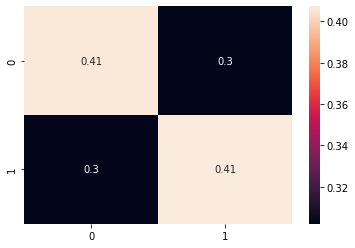

In [ ]:
sample_style_image = Image.open(sample_style_image_path).convert("L")
sample_style_image = function_testing_transform(sample_style_image)

sample_content_image = Image.open(sample_content_image_path).convert("L")
sample_content_image = function_testing_transform(sample_content_image)

print(sample_style_image.shape)
print(sample_content_image.shape)

print("=" * 50)
print("This is the gram matrix that shows correlation between each channels: ")
two_channels_image = torch.cat([sample_style_image, sample_content_image], axis = 0)
gram_matrix = get_gram(two_channels_image.unsqueeze(0))
print("=" * 50)
sns.heatmap(gram_matrix, annot = True)

Style Loss algorithm

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self, style_image):
    super(StyleLoss, self).__init__()
    self.style_image_gram_matrix = get_gram(style_image) # For the purpose of visualization and debugging, we store the .

  def forward(self, generated_image):
    self.generated_image_gram_matrix = get_gram(generated_image)
    style_loss = F.mse_loss(
      self.generated_image_gram_matrix, 
      self.style_image_gram_matrix
    )
    return style_loss

In [ ]:
sample_style_image = Image.open(sample_style_image_path).convert("L")
sample_style_image = function_testing_transform(sample_style_image)

sample_generated_image = Image.open(sample_content_image_path).convert("L")
sample_generated_image = function_testing_transform(sample_generated_image)

style_loss = StyleLoss(sample_style_image.unsqueeze(0))
loss_value = style_loss(sample_generated_image.unsqueeze(0))

print(f"Loss value is: {loss_value}")

Loss value is: 3.605310666898731e-06


In [ ]:
sample_style_image = Image.open(sample_style_image_2_path).convert("L")
sample_style_image = function_testing_transform(sample_style_image)

sample_content_image = Image.open(sample_content_image_path).convert("L")
sample_content_image = function_testing_transform(sample_content_image)

style_loss = StyleLoss(sample_style_image.unsqueeze(0))
loss_value = style_loss(sample_content_image.unsqueeze(0))

print(f"Loss value is: {loss_value}")

Loss value is: 0.008407318964600563


Content Loss Algorithm

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, content_image):
    super(ContentLoss, self).__init__()
    self.content_image = content_image
    
  def forward(self, generated_image):
    return F.mse_loss(generated_image, self.content_image)

In [ ]:
sample_generated_image = Image.open(sample_style_image_path).convert("L")
sample_generated_image = function_testing_transform(sample_generated_image)

sample_content_image = Image.open(sample_content_image_path).convert("L")
sample_content_image = function_testing_transform(sample_content_image)

content_loss = ContentLoss(sample_generated_image.unsqueeze(0))
loss_value = content_loss(sample_content_image.unsqueeze(0))

print(f"Loss value is: {loss_value}")

Loss value is: 0.4189099073410034


In [ ]:
sample_generated_image = Image.open(sample_style_image_2_path).convert("L")
sample_generated_image = function_testing_transform(sample_generated_image)

sample_content_image = Image.open(sample_content_image_path).convert("L")
sample_content_image = function_testing_transform(sample_content_image)

content_loss = ContentLoss(sample_generated_image.unsqueeze(0))
loss_value = content_loss(sample_content_image.unsqueeze(0))

print(f"Loss value is: {loss_value}")

Loss value is: 0.6999353170394897


### It's Showtime!

In [ ]:
def turn_off_grad_pretained_model(pretrained_model):
  for param in pretrained_model.parameters():
    param.requires_grad = False

class StyleTransferModel(nn.Module):
  def __init__(self):
    super(StyleTransferModel, self).__init__()
    self.max_layer_index = None
    self.layer_outputs_filter = [torch.nn.modules.activation.ReLU]
    self.style_transfer_model = None

    # Filter layers, as we don't want to process DUPLICATE layers.
    # E.g. Sequentials, SqueezeExcitation, etc.
    self.flatten_layers_exception = [torch.nn.modules.container.Sequential]

  def __flatten_layers_from_model__(self):
    # Get all the model layers, except Sequential Layers, 
    # since we'd like to iterate the layers one by one.
    model_layers = list(self.style_transfer_model.modules())[1:]
    flattened_model_layers = []

    for index, layer in enumerate(model_layers):
      # print(type(layer))
      if type(layer) not in self.flatten_layers_exception:
        flattened_model_layers.append(layer)

      if index is not None and index == self.max_layer_index:
        break

    return flattened_model_layers

  def __get_non_duplicated_layers__(self):
    non_sequential_layers = self.__flatten_layers_from_model__()
    return non_sequential_layers
    
  def print_model_layers(self):
    print("==========================================================")
    print("Layer Names:")
    layers = self.__get_non_duplicated_layers__()
    for index, layer in enumerate(layers):
      print(f"{index}: {layer}")
    print("==========================================================")

  def print_selected_layers_from_architecture(self):
    """
    COMING SOON!
    """
    print(self.style_transfer_model)

  def print_model_weights(self):
    print("==========================================================")
    print("Model Weights: ")
    model_weights = self.style_transfer_model.state_dict()
    layer_names = model_weights.keys()
    for layer_name in layer_names:
      print(f"{layer_name}: {model_weights[layer_name].shape}")
    print("==========================================================")

  def forward(self, x):
    layers = self.__get_non_duplicated_layers__()
    selected_layer_outputs = []
    for index, layer in enumerate(layers):
      # print(f"Index number: {index}")
      x = layer(x)
      if type(layer) in self.layer_outputs_filter:
        selected_layer_outputs.append(x)

    return selected_layer_outputs

class VGG16StyleTransferModel(StyleTransferModel):
  def __init__(self):
    super(VGG16StyleTransferModel, self).__init__()
    self.max_layer_index = 29
    self.style_transfer_model = models.vgg16(pretrained = True)
    turn_off_grad_pretained_model(self.style_transfer_model)
  
class AlexNetStyleTransferModel(StyleTransferModel):
  def __init__(self):
    super(AlexNetStyleTransferModel, self).__init__()
    self.max_layer_index = 11
    self.style_transfer_model = models.alexnet(pretrained = True)
    turn_off_grad_pretained_model(self.style_transfer_model)

class MobileNetV2StyleTransferModel(StyleTransferModel):
  def __init__(self):
    super(MobileNetV2StyleTransferModel, self).__init__()
    self.max_layer_index = 138
    self.layer_outputs_filter = [torch.nn.modules.activation.ReLU6]
    self.flatten_layers_exception = [
        torch.nn.modules.container.Sequential,
        torchvision.ops.Conv2dNormActivation,
        torchvision.ops.SqueezeExcitation,
        torchvision.models.mobilenetv2.InvertedResidual
    ]
    self.style_transfer_model = models.mobilenet_v2(pretrained = True)
    turn_off_grad_pretained_model(self.style_transfer_model)

class EfficientNetStyleTransferModel(StyleTransferModel):
  def __init__(self):
    super(EfficientNetStyleTransferModel, self).__init__()
    self.max_layer_index = 78
    self.layer_outputs_filter = [torch.nn.modules.activation.SiLU]
    self.flatten_layers_exception = [
        torch.nn.modules.container.Sequential,
        torchvision.ops.Conv2dNormActivation,
        torchvision.ops.SqueezeExcitation,
        torchvision.models.efficientnet.FusedMBConv,
        torchvision.models.efficientnet.MBConv,
    ]
    self.style_transfer_model = models.efficientnet_v2_m(pretrained = True)
    turn_off_grad_pretained_model(self.style_transfer_model)

vgg16_style_transfer_model = VGG16StyleTransferModel().to(device).eval()
alexnet_style_transfer_model = AlexNetStyleTransferModel().to(device).eval()
mobilenetv2_style_transfer_model = MobileNetV2StyleTransferModel().to(device).eval()
efficientnet_style_transfer_model = EfficientNetStyleTransferModel().to(device).eval()

In [ ]:
vgg16_style_transfer_model.print_model_layers()
vgg16_style_transfer_model.print_model_weights()

Layer Names:
0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1: ReLU(inplace=True)
2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3: ReLU(inplace=True)
4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6: ReLU(inplace=True)
7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8: ReLU(inplace=True)
9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11: ReLU(inplace=True)
12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13: ReLU(inplace=True)
14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15: ReLU(inplace=True)
16: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18: ReLU(inplace=True)
19: Co

In [ ]:
alexnet_style_transfer_model.print_model_layers()
alexnet_style_transfer_model.print_model_weights()

Layer Names:
0: Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
1: ReLU(inplace=True)
2: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
3: Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
4: ReLU(inplace=True)
5: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
6: Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7: ReLU(inplace=True)
8: Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9: ReLU(inplace=True)
10: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Model Weights: 
features.0.weight: torch.Size([64, 3, 11, 11])
features.0.bias: torch.Size([64])
features.3.weight: torch.Size([192, 64, 5, 5])
features.3.bias: torch.Size([192])
features.6.weight: torch.Size([384, 192, 3, 3])
features.6.bias: torch.Size([384])
features.8.weight: torch.Size([256, 384, 3, 3])
features.8.bias: torch.Size([256])
features.10.weight: torch.Size([256, 256, 3,

In [ ]:
mobilenetv2_style_transfer_model.print_model_layers()
mobilenetv2_style_transfer_model.print_model_weights()

Layer Names:
0: Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
1: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2: ReLU6(inplace=True)
3: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
4: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
5: ReLU6(inplace=True)
6: Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
7: BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
8: Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
9: BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
10: ReLU6(inplace=True)
11: Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
12: BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
13: ReLU6(inplace=True)
14: Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
15: BatchNorm2d(

In [ ]:
efficientnet_style_transfer_model.print_model_layers()
efficientnet_style_transfer_model.print_model_weights()

Layer Names:
0: Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
1: BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
2: SiLU(inplace=True)
3: Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
4: BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
5: SiLU(inplace=True)
6: StochasticDepth(p=0.0, mode=row)
7: Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
8: BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
9: SiLU(inplace=True)
10: StochasticDepth(p=0.0035087719298245615, mode=row)
11: Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
12: BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
13: SiLU(inplace=True)
14: StochasticDepth(p=0.007017543859649123, mode=row)
15: Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
16: BatchNorm2

Define Optimizer

In [ ]:
def get_input_optimizer(input_image):
  # Heard that LBFGS is faster than Adam, and it's also perform as optimally as Adam!
  optimizer = optim.LBFGS([input_image.requires_grad_()])
  return optimizer

Let's test the model in action!

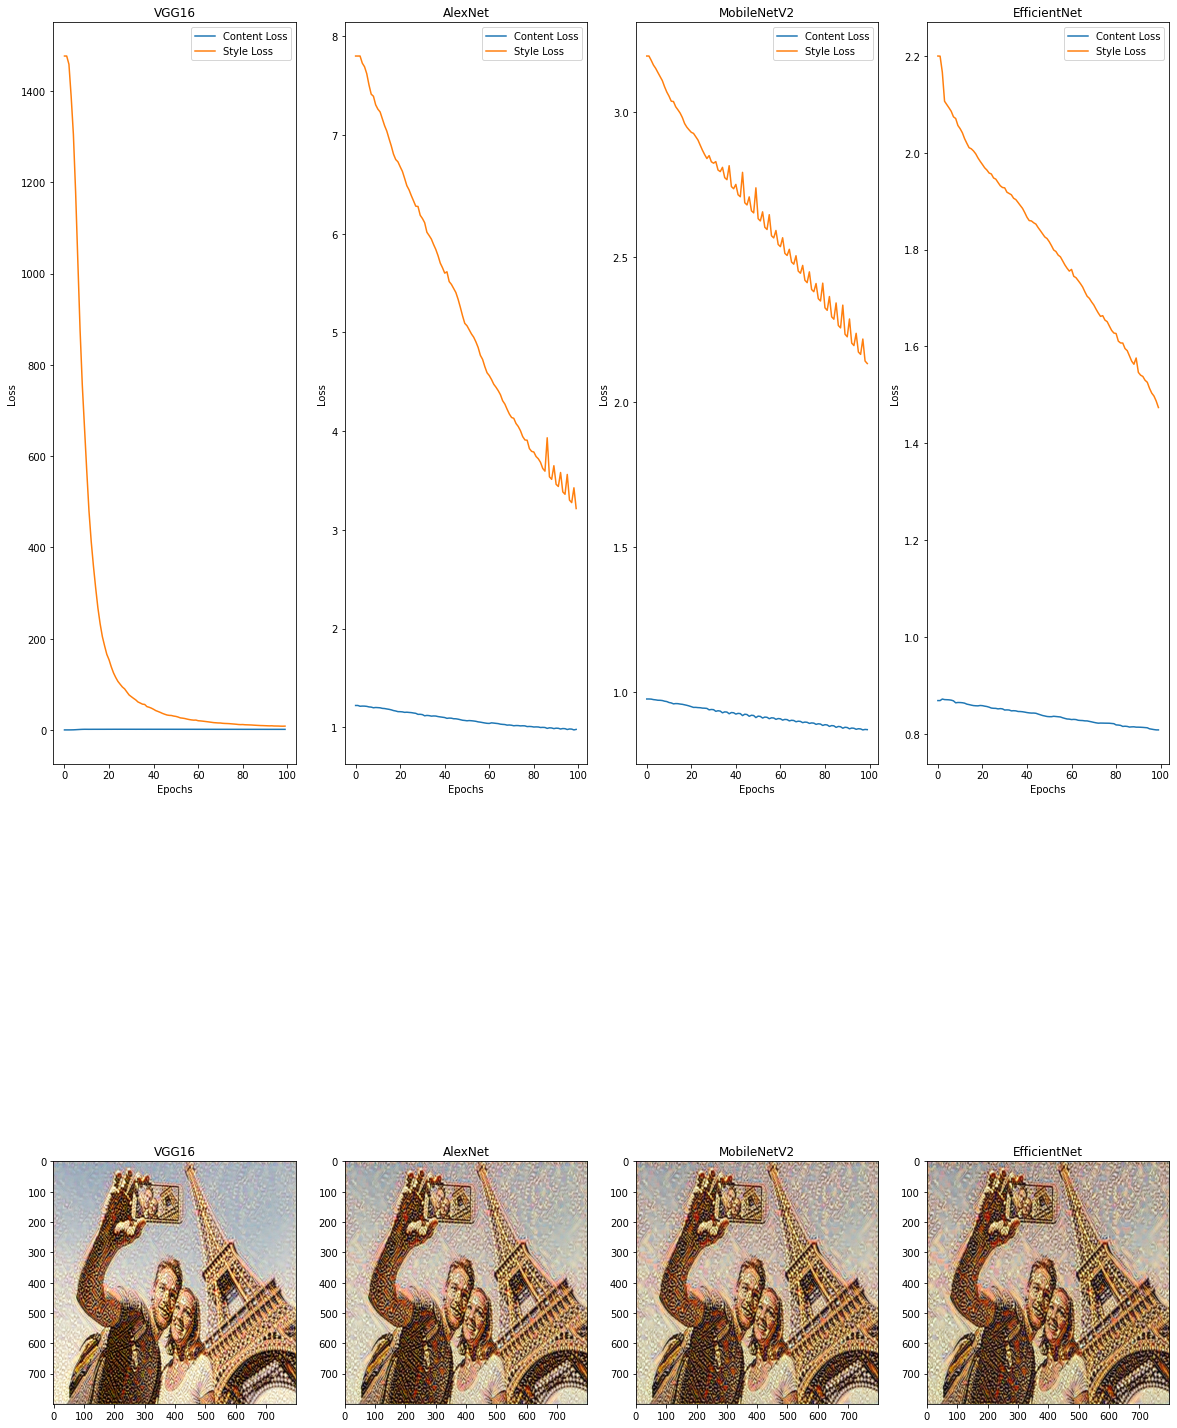

In [ ]:
sample_content_image_path = f"{neural_style_transfer_dataset_directory}/Orang Berfoto.jpg"
sample_style_image_path = f"{neural_style_transfer_dataset_directory}/Batik 1.jpg"

sample_style_image = Image.open(sample_style_image_path).convert("RGB")
sample_style_image = image_transform(sample_style_image)
sample_style_image = sample_style_image.unsqueeze(0)
sample_style_image = sample_style_image.to(device)

sample_content_image = Image.open(sample_content_image_path).convert("RGB")
sample_content_image = image_transform(sample_content_image)
sample_content_image = sample_content_image.unsqueeze(0)
sample_content_image = sample_content_image.to(device)

# Copy from sample content image.
# Note: We don't have to make the model exhausted from training by feedforwarding the content_image
# Instead, just clone the image!
sample_input_image = sample_content_image.clone()
sample_input_image.requires_grad = True
sample_input_image = sample_input_image.to(device)

def perform_style_transfer(model, optimizer, style_image, content_image, input_image, number_of_epochs = 100, style_weight = 1000000, content_weight = 1, verbose = False):
  # WARNING: Style image and content image must be in Tensor.
  # It has to be preprocessed as well.
  
  content_losses = []
  style_losses = []

  for epoch in range(0, number_of_epochs):
    content_image_outputs = model(content_image)
    input_image_outputs = model(input_image)
    style_image_outputs = model(style_image)

    optimizer.zero_grad()

    # Process Content Loss.
    # Recall, content loss has always to be the last of our specified layers!

    last_output_content_image_layer = content_image_outputs[-1]
    last_output_input_image_layer = input_image_outputs[-1]

    content_loss_func = ContentLoss(last_output_content_image_layer)
    content_loss = content_loss_func(last_output_input_image_layer)

    # Process Style Loss.
    # Recall, Style Loss occurs in all of our specified layers.

    number_of_outputs = len(input_image_outputs)
    total_style_loss = 0

    for output_index in range(0, number_of_outputs):
      input_image_layer_loss = input_image_outputs[output_index]
      style_image_layer_loss = style_image_outputs[output_index]
      style_loss_func = StyleLoss(style_image_layer_loss)
      style_loss = style_loss_func(input_image_layer_loss)

      total_style_loss += style_loss

    # Finally, Perform Weighted Loss.
    # Which loss to prioritize? Content Loss or Style Loss? It's up to you!
    
    weighted_content_loss = content_loss * content_weight
    weighted_style_loss = total_style_loss * style_weight

    total_weighted_loss = weighted_content_loss + weighted_style_loss
    total_weighted_loss.backward()

    content_losses.append(weighted_content_loss.item())
    style_losses.append(weighted_style_loss.item())

    def closure():
      return total_weighted_loss
    optimizer.step(closure)

    if verbose:
      # Visualize the Result.
      print("=" * 50)
      print(f"Current Epoch: {epoch + 1}")
      print(f"Content Loss: {weighted_content_loss.item()}")
      print(f"Style Loss: {weighted_style_loss.item()}")
      print(f"Total Weighted Loss: {total_weighted_loss.item()}")
      print("=" * 50)

  return input_image, content_losses, style_losses

def denormalize_img(inp, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
  inp = inp.transpose((1, 2, 0))
  # Inverse mean and standard deviation.
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

def plot_loss_model(content_losses, style_losses, ax):
  ax.plot(content_losses, label='Content Loss')
  ax.plot(style_losses,label='Style Loss')
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  ax.legend()

def plot_result_image(tensor_image, ax):
  final_result_vis_image = final_result_image
  final_result_vis_image = final_result_image.squeeze(0).detach().cpu().numpy()
  final_result_vis_image = denormalize_img(final_result_vis_image)
  ax.imshow(final_result_vis_image)

vgg16_style_transfer_model = VGG16StyleTransferModel().to(device).eval()
alexnet_style_transfer_model = AlexNetStyleTransferModel().to(device).eval()
mobilenetv2_style_transfer_model = MobileNetV2StyleTransferModel().to(device).eval()
efficientnet_style_transfer_model = EfficientNetStyleTransferModel().to(device).eval()

titles = ["VGG16", "AlexNet", "MobileNetV2", "EfficientNet"]
style_transfer_models = [
    vgg16_style_transfer_model,
    alexnet_style_transfer_model, 
    mobilenetv2_style_transfer_model,
    efficientnet_style_transfer_model
]

N_ROWS = 2
N_COLS = 4
fig, axes = plt.subplots(nrows = N_ROWS, ncols = N_COLS, figsize = (20, 30))

for col_index in range(0, N_COLS):
  current_loss_ax = axes[0][col_index]
  current_result_image_ax = axes[1][col_index]
  title = titles[col_index]

  current_loss_ax.set_title(title)
  current_result_image_ax.set_title(title)

  final_result_image, content_losses, style_losses = perform_style_transfer(
    vgg16_style_transfer_model,
    optimizer = get_input_optimizer(sample_input_image),
    style_image = sample_style_image, 
    content_image = sample_content_image, 
    input_image = sample_input_image,
  )

  plot_loss_model(content_losses, style_losses, current_loss_ax)
  plot_result_image(final_result_image, current_result_image_ax)

plt.show()

## Data Modelling 2

Below is the model architecture that we'll implement.

![Fast Neural Style Transfer](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/613ebf63d399e5f400cce8f8_neural-style-transfer-basic-structure.png)